In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CSV einlesen
df = pd.read_csv('../data/processed/usa_model_dataset.csv')

# Historische Daten für später
historical_data = df[df['Year'] <= 2017]
years_historical = historical_data['Year'].values
true_total = historical_data['CO2_total'].values

# Ursprüngliche Features
base_features = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Rolling Average anwenden
df[base_features] = df[base_features].rolling(window=3, min_periods=1).mean()

# Lags erzeugen (Lag 1 & 2 für ausgewählte Features)
lag_features = ['GDP', 'Energy_intensity']
for col in lag_features:
    for lag in [1, 2]:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# NaNs entfernen
df.dropna(inplace=True)

# Input-Features aktualisieren
input_features = base_features + [f"{col}_lag{lag}" for col in lag_features for lag in [1, 2]]

# Zielvariablen
target_columns = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Daten bis 2017
df_model = df[df['Year'] <= 2017].copy()

# Skalierung
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df_model[input_features])
y_scaled = target_scaler.fit_transform(df_model[target_columns])

# Fenstergröße
window_size = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - window_size):
    X_seq.append(X_scaled[i:i + window_size])
    y_seq.append(y_scaled[i + window_size])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/Test Split (zeitlich korrekt)
n_train = df_model[df_model['Year'] <= 2005].shape[0]
X_train = X_seq[:n_train - window_size]
y_train = y_seq[:n_train - window_size]
X_test = X_seq[n_train - window_size:]
y_test = y_seq[n_train - window_size:]

# Modell
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(window_size, len(input_features))))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=len(target_columns)))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Vorhersage auf dem Testdatensatz (skaliert)
y_pred_scaled = model.predict(X_test)

# Rücktransformation in Originaleinheiten
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Rücktransformation in Originaleinheiten
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Fehler-Metriken pro Zielvariable (CO₂-Komponenten)
for i, col in enumerate(target_columns):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])

    print(f"{col}:")
    print(f"  Mittlere absolute Abweichung (MAE): {mae:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Bestimmtheitsmaß (R²): {r2:.3f}\n")

# Zeitraum 2013–2017 extrahieren
trend_df = df[(df['Year'] >= 2013) & (df['Year'] <= 2017)].reset_index(drop=True)

# Spalten, für die die Wachstumsrate berechnet werden soll
columns_to_analyze = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Wachstumsraten berechnen
trend_results = []
for col in columns_to_analyze:
    start_value = trend_df.iloc[0][col]
    end_value = trend_df.iloc[-1][col]
    n_years = trend_df.iloc[-1]['Year'] - trend_df.iloc[0]['Year']
    growth_rate = (end_value / start_value) ** (1 / n_years) - 1
    trend_results.append({
        'Feature': col,
        'Startwert': start_value,
        'Endwert': end_value,
        'Jahreswachstum': growth_rate
    })

# In DataFrame umwandeln und runden
trend_table = pd.DataFrame(trend_results)
trend_table['Jahreswachstum'] = (trend_table['Jahreswachstum'] * 100).round(3)  # in Prozent
trend_table = trend_table.round(2)

# Tabelle anzeigen
print(trend_table)

# Wachstumsraten als Dictionary (dezimal)
growth = dict(zip(trend_table['Feature'], (trend_table['Jahreswachstum'] / 100).values))

Epoch 1/500


C:\Users\belav\IdeaProjects\group14-co2-NetZeroTrackers\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2586 - mae: 0.4364 - val_loss: 0.0692 - val_mae: 0.2025
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0641 - mae: 0.2081 - val_loss: 0.1028 - val_mae: 0.2578
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0416 - mae: 0.1628 - val_loss: 0.1127 - val_mae: 0.2728
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0402 - mae: 0.1607 - val_loss: 0.1076 - val_mae: 0.2575
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0368 - mae: 0.1517 - val_loss: 0.1266 - val_mae: 0.2817
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0254 - mae: 0.1240 - val_loss: 0.1766 - val_mae: 0.3377
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0263 - mae: 0.1296 - val_loss: 0.2037 - val_mae: 0.3673
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0225 - mae: 0.1185 - val_loss: 0.1899 - val_mae: 0.3490
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0276 - mae: 0.1292 - val_


Szenario A – Business as Usual (direkte Entwicklung):
 Year   CO2_total    CO2_coal     CO2_oil     CO2_gas  CO2_cement
 2018 5075.424872 1222.209872 2338.328770 1473.509773   41.376456
 2019 5032.066898 1141.421800 2361.712058 1486.476659   42.456382
 2020 4994.425144 1065.973819 2385.329178 1499.557653   43.564493
 2021 4962.150707  995.512949 2409.182470 1512.753761   44.701527
 2022 4934.918069  929.709543 2433.274295 1526.065994   45.868237
 2023 4912.423553  868.255743 2457.607038 1539.495375   47.065398
 2024 4894.383884  810.864038 2482.183108 1553.042934   48.293804
 2025 4880.534849  757.265925 2507.004939 1566.709712   49.554273
 2026 4870.630032  707.210647 2532.074989 1580.496757   50.847639
 2027 4864.439653  660.464024 2557.395738 1594.405129   52.174763
 2028 4861.749465  616.807352 2582.969696 1608.435894   53.536524
 2029 4862.359735  576.036386 2608.799393 1622.590130   54.933827
 2030 4866.084290  537.960381 2634.887387 1636.868923   56.367600
 2031 4872.749624  50

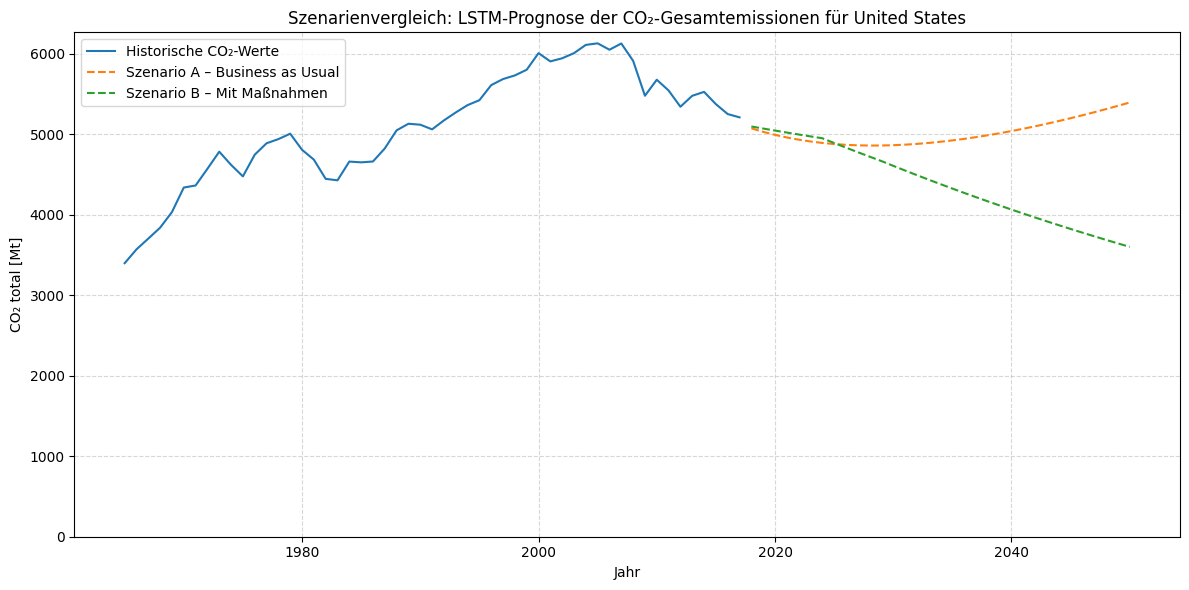

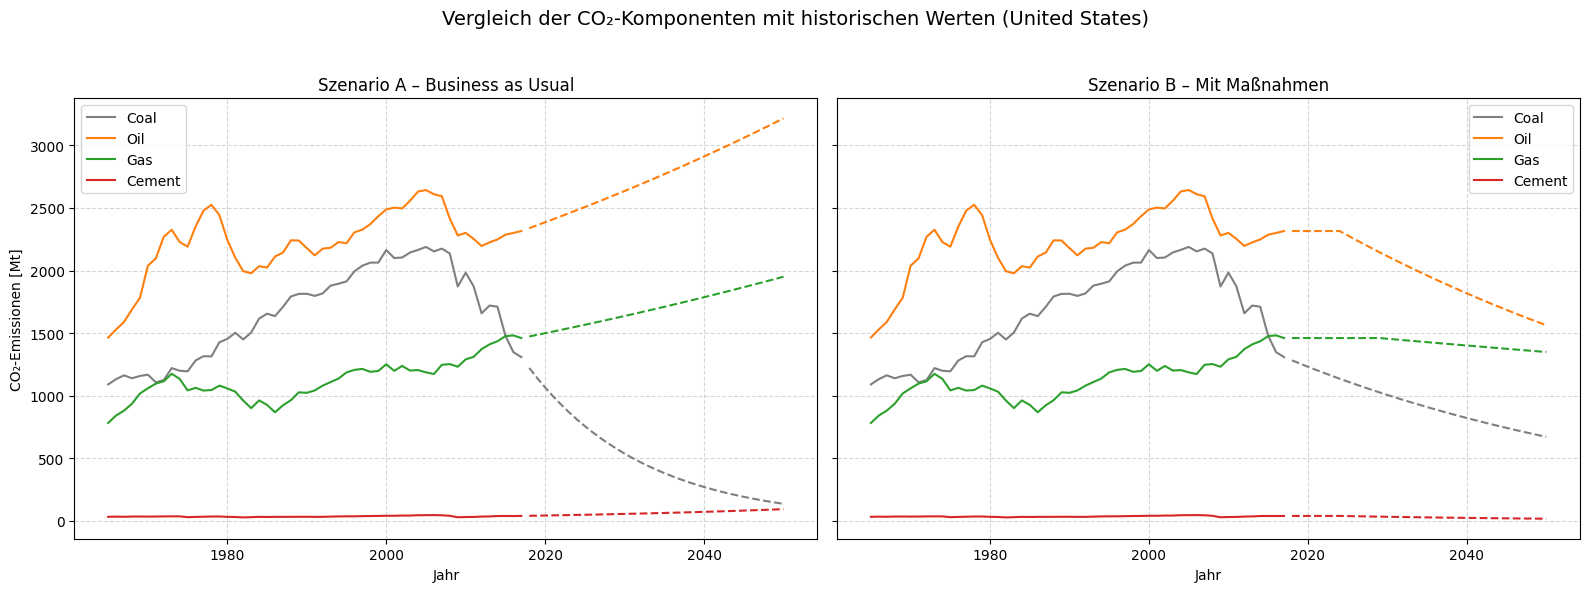

In [4]:
import os

# Zielvariablen definieren
target_columns = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Prognosezeitraum
future_years = list(range(2018, 2051))

# Wachstumsraten für BAU – für United States (Durchschnitt 2013–2017)
growth = {
    'GDP': 0.0221,                  # 2.21 %
    'Population': 0.0094,           # 0.94 %
    'Primary_energy': 0.0026,       # 0.26 %
    'Energy_intensity': -0.0191,    # -1.91 %
    'CO2_coal': -0.0661,            # -6.61 %
    'CO2_oil': 0.0100,              # 1.00 %
    'CO2_gas': 0.0088,              # 0.88 %
    'CO2_cement': 0.0261,           # 2.61 %
    'Urban_population_pct': 0.0023, # 0.23 %
    'Trade_share_GDP': -0.0288,     # -2.88 %
    'GDP_growth_annual': 0.0425     # 4.25 %
}

# Letzter bekannter Datenpunkt (2017)
last_row = df_model[input_features + target_columns].iloc[-1].copy()
last_row['Year'] = 2017
last_row['CO2_total'] = last_row['CO2_coal'] + last_row['CO2_oil'] + last_row['CO2_gas'] + last_row['CO2_cement']

bau = last_row.copy()
measures = last_row.copy()

bau_rows = []
measure_rows = []

# Iteration über Zieljahre
for year in future_years:
    # BAU – normales Wachstum
    row_bau = bau.copy()
    row_bau['Year'] = year
    for key in growth:
        if key in row_bau:
            row_bau[key] *= (1 + growth[key])

    # Maßnahmen – direkte Eingriffe
    row_mea = measures.copy()
    row_mea['Year'] = year

    # Allgemeine wirtschaftliche Variablen (etwas abgeschwächt)
    row_mea['GDP'] *= 1.02
    row_mea['Population'] *= 1.006
    row_mea['Urban_population_pct'] *= 1.0226
    row_mea['Trade_share_GDP'] *= 0.9492
    row_mea['Primary_energy'] *= 0.98  # optionaler Rückgang

    # CO₂-Eingriffe
    if year >= 2018:
        row_mea['CO2_coal'] *= (1 - 0.02)  # -2 %/Jahr ab 2018

    if year >= 2025:
        row_mea['CO2_oil'] *= (1 - 0.015)  # -1.5 %/Jahr
        base_energy_intensity = row_mea['Energy_intensity'] / (1 + growth['Energy_intensity'])
        row_mea['Energy_intensity'] = base_energy_intensity * (1 - 0.06)  # -6 %/Jahr
        base_cement = row_mea['CO2_cement'] / (1 + growth['CO2_cement'])
        row_mea['CO2_cement'] = base_cement * (1 - 0.005)  # -0.5 %/Jahr

    if year >= 2030:
        base_gas = row_mea['CO2_gas'] / (1 + growth['CO2_gas'])
        row_mea['CO2_gas'] = base_gas * (1 + 0.005)  # leicht +0.5 % pro Jahr

    # CO2_total jeweils berechnen
    row_bau['CO2_total'] = row_bau['CO2_coal'] + row_bau['CO2_oil'] + row_bau['CO2_gas'] + row_bau['CO2_cement']
    row_mea['CO2_total'] = row_mea['CO2_coal'] + row_mea['CO2_oil'] + row_mea['CO2_gas'] + row_mea['CO2_cement']

    # Speichern
    bau_rows.append(row_bau.copy())
    measure_rows.append(row_mea.copy())

    # Update für nächste Iteration
    bau = row_bau.copy()
    measures = row_mea.copy()

# DataFrames erzeugen
df_bau_direct = pd.DataFrame(bau_rows)
df_mea_direct = pd.DataFrame(measure_rows)

# Vorschau
print("\nSzenario A – Business as Usual (direkte Entwicklung):")
df_bau_direct['Year'] = df_bau_direct['Year'].astype(int)
print(df_bau_direct[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].to_string(index=False))

print("\nSzenario B – Mit Maßnahmen (direkte Eingriffe):")
df_mea_direct['Year'] = df_mea_direct['Year'].astype(int)
print(df_mea_direct[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].to_string(index=False))

# Ergebnisordner erstellen und speichern
output_folder = '../data/results/szenario_prognose_usa_lsmt/'
os.makedirs(output_folder, exist_ok=True)

df_bau_direct.to_csv(os.path.join(output_folder, 'usa_bau.csv'), index=False)
df_mea_direct.to_csv(os.path.join(output_folder, 'usa_measures.csv'), index=False)

print(f"\n Prognosedateien gespeichert in: {output_folder}")

# Plot-Stil
plt.figure(figsize=(12, 6))

# Historische Daten bis 2017
plt.plot(historical_data['Year'], historical_data['CO2_total'], label='Historische CO₂-Werte', color='tab:blue')

# Prognose – BAU
plt.plot(df_bau_direct['Year'], df_bau_direct['CO2_total'], linestyle='--', color='tab:orange', label='Szenario A – Business as Usual')

# Prognose – Maßnahmen
plt.plot(df_mea_direct['Year'], df_mea_direct['CO2_total'], linestyle='--', color='tab:green', label='Szenario B – Mit Maßnahmen')

# Titel und Achsenbeschriftungen
plt.title('Szenarienvergleich: LSTM-Prognose der CO₂-Gesamtemissionen für United States')
plt.xlabel('Jahr')
plt.ylabel('CO₂ total [Mt]')

# Legende
plt.legend()

# Achsenbegrenzung optional
plt.ylim(bottom=0)

# Raster
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Farben pro Komponente – konsistent
colors = {
    'CO2_coal': 'tab:gray',
    'CO2_oil': 'tab:orange',
    'CO2_gas': 'tab:green',
    'CO2_cement': 'tab:red'
}

# Historische Daten extrahieren
historical_co2 = historical_data[['Year', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']]

# Subplots: 1 Zeile, 2 Spalten
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# 1. Plot – Business as Usual
for col in colors.keys():
    # Historische Werte
    axes[0].plot(historical_co2['Year'], historical_co2[col], linestyle='-', label=col.replace('CO2_', '').capitalize(), color=colors[col])
    # Prognose
    axes[0].plot(df_bau_direct['Year'], df_bau_direct[col], linestyle='--', color=colors[col])

axes[0].set_title('Szenario A – Business as Usual')
axes[0].set_xlabel('Jahr')
axes[0].set_ylabel('CO₂-Emissionen [Mt]')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# 2. Plot – Mit Maßnahmen
for col in colors.keys():
    # Historische Werte
    axes[1].plot(historical_co2['Year'], historical_co2[col], linestyle='-', label=col.replace('CO2_', '').capitalize(), color=colors[col])
    # Prognose
    axes[1].plot(df_mea_direct['Year'], df_mea_direct[col], linestyle='--', color=colors[col])

axes[1].set_title('Szenario B – Mit Maßnahmen')
axes[1].set_xlabel('Jahr')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Layout und Titel
plt.suptitle('Vergleich der CO₂-Komponenten mit historischen Werten (United States)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()